In [1]:
%run ./ipy_setup.py

In [2]:
%matplotlib inline

In [3]:
import os
import sys
import pysam
import vcf
import itertools
import string
import numpy as np
from collections import Counter
from copy import deepcopy

In [4]:
def readVcfToDict (vcf_reader, sample_id = "hg002"):
    snpChromDict = {}
    snpChromDictUnphased = {}
    chrom = None
    rcount = 0
    for record in vcf_reader:
        #print record
        rcount += 1
        if chrom != record.CHROM:
            print >>sys.stderr, "...reading chrom %s" %(record.CHROM)
            snpChromDict.setdefault(record.CHROM, {})
            snpChromDictUnphased.setdefault(record.CHROM, {})
        if rcount % 1000 == 0:
            print >>sys.stderr, "...read %s vars" %(rcount)
        if record.CHROM != "000000F":
            print >>sys.stderr, "...exiting out of function early after first contig"
            return snpChromDict, snpChromDictUnphased
        chrom, ref, alt, pos = record.CHROM, record.REF, record.ALT, record.POS

        gt_sample = record.genotype(sample_id)['GT']
        if gt_sample != None:
            if "|" in gt_sample:
                mat_gt, pat_gt = map(int, gt_sample.split("|"))
                if mat_gt == pat_gt:
                    continue
                snpChromDict[chrom][int(pos)] = (mat_gt, pat_gt)
            if "/" in gt_sample:
                mat_gt, pat_gt = map(int, gt_sample.split("/"))
                if mat_gt == pat_gt:
                    continue
                snpChromDictUnphased[chrom][int(pos)] = (mat_gt, pat_gt)
    return snpChromDict, snpChromDictUnphased

In [5]:
def parseHapCutOut (hapcutoutfn):
    with open (hapcutoutfn) as f:
        f.readline()
        block = []
        for l in f:
            if l[0] == "B":
                yield block
                block = []
            else:
                ll = l.split("\t")
                if len(ll) > 5:
                    hap1, hap2, chrom, pos = ll[1:5]
                    hap1, hap2, pos = int(hap1), int(hap2), int(pos)
                    block.append((hap1, hap2, chrom, pos))
                
        yield block

In [7]:
def calculateSwitchError (switch_list):
    switches = 0
    if len(switch_list) == 0:
        return switches, 0
    curr_s = switch_list[0]
    for s in switch_list[1:]:
        if s != curr_s:
            switches += 1
        curr_s = s
    if len(switch_list) == 1:
        return 0, 0
    else:
        return switches, switches/(float(len(switch_list))-1)

In [9]:
def measureBlockConcordance (block, snpDict, snpDictUnphased={}):
    pcount = 0
    mcount = 0
    missing_from_trio = 0
    missing_from_file = 0
    missing_other = 0
    switch_list = []
    for var in block:
        pos = var[3]
        if pos in snpDict:
            if snpDict[pos][0] == var[0]:
                mcount += 1
                switch_list.append(0)
            elif snpDict[pos][1] == var[0]:
                pcount += 1
                switch_list.append(1)
            else:
                missing_other += 1
        elif pos in snpDictUnphased:
            missing_from_trio += 1
        else:
            missing_from_file += 1
    if missing_from_trio + missing_from_file == len(block):
        return 0, max(pcount, mcount), missing_from_trio, missing_from_file, missing_other, switch_list
    else:
        denom = (len(block)-missing_from_trio-missing_from_file)
        return float(max(pcount, mcount))/denom, max(pcount, mcount), missing_from_trio, missing_from_file, missing_other, switch_list


In [10]:
def measureBlockConcordanceWithPos (block, snpDict, snpDictUnphased={}):
    pcount = 0
    mcount = 0
    missing_from_trio = 0
    missing_from_file = 0
    missing_other = 0
    switch_list = []
    switchpos_list = []
    for var in block:
        pos = var[3]
        if pos in snpDict:
            if snpDict[pos][0] == var[0]:
                mcount += 1
                switch_list.append(0)
                switchpos_list.append(pos)
            elif snpDict[pos][1] == var[0]:
                pcount += 1
                switch_list.append(1)
                switchpos_list.append(pos)
            else:
                missing_other += 1
        elif pos in snpDictUnphased:
            missing_from_trio += 1
        else:
            missing_from_file += 1
    if missing_from_trio + missing_from_file == len(block):
        return 0, max(pcount, mcount), missing_from_trio, missing_from_file, missing_other, switch_list, \
    switchpos_list
    else:
        denom = (len(block)-missing_from_trio-missing_from_file)
        return float(max(pcount, mcount))/denom, max(pcount, mcount), missing_from_trio, missing_from_file, \
    missing_other, switch_list, switchpos_list


In [11]:
def calculateX50 ( rawvals ):
    vals = deepcopy(rawvals)
    vals.sort(reverse=True)
    vsum = sum(vals)
    currsum = 0
    for v in vals:
        currsum += v
        if currsum >= .5*vsum:
            return v

In [12]:
def getVCF(vcffn):
    print >>sys.stderr, "opening vcf file %s" %(vcffn)
    vcf_reader = vcf.Reader(filename=vcffn)
    print >>sys.stderr, "reading vcf file . . ."
    snpChromDict, snpChromDictUnphased = readVcfToDict (vcf_reader)
    print >>sys.stderr, "finished reading vcf file"
    return snpChromDict, snpChromDictUnphased

In [13]:
def phaseLocalRegions (snpChromDict, snpChromDictUnphased, hapcutfn):    
    blocklens = []
    blockspans = []
    bs = []
    triomissings = []
    filemissings = []
    concordances = []
    concounts = []
    switch_counts = []
    switch_errors = []
    othermissings = []
    switch_list_all = []
    switchpos_list_all = []
    print >>sys.stderr, "reading hapcut blocks: "
    bcount = 0
    for block in parseHapCutOut(hapcutfn):
        bcount += 1
        if bcount % 10000 == 0:
            print >>sys.stderr, ". . . read %i blocks" %(bcount)
        positions = map(lambda x: x[3], block)
        span = max(positions)-min(positions)
        blocklens.append(len(positions))
        blockspans.append(span)
        bs.append([min(positions), max(positions)])
        chrom = block[0][2]
        concordance, concount, triomissing, filemissing, othermissing, switch_list, switchpos_list = \
            measureBlockConcordanceWithPos ( block, snpChromDict[chrom], snpChromDictUnphased[chrom])
        switches, switch_error = calculateSwitchError (switch_list)
        switch_counts.append(switches)
        switch_errors.append(switch_error)
        switch_list = [abs(i) for i in np.diff(switch_list)]
        switch_list_all.extend(switch_list)
        switchpos_list_all.extend(switchpos_list[0:-1])
        triomissings.append(triomissing)
        concordances.append(concordance)
        filemissings.append(filemissing)
        othermissings.append(othermissing)
        concounts.append(concount)
    denomsum = sum(blocklens) -  sum(filemissings) - sum(triomissings)
    conrate = sum(concounts)/float(denomsum)
    switchrate = float(sum(switch_counts))/denomsum
    print "switches              : %i" %(sum(switch_counts))
    print "concordant snps       : %i" %(sum(concounts))
    print "total snps in blocks  : %i" %(sum(blocklens))
    print "missing from trio snps: %i" %(sum(triomissings))
    print "missing from file snps: %i" %(sum(filemissings))
    print "other missing     snps: %i" %(sum(othermissings))
    print "denominator snps      : %i" %(denomsum)
    print "haplotype accuracy    : %f" %(conrate)
    print "switch error rate     : %f" %(switchrate)
    
    print "S50: %i" %(calculateX50 ( blocklens ))
    print "N50: %i" %(calculateX50 ( blockspans ))
    return concordance, concount, triomissing, filemissing, othermissing, switch_list_all, switchpos_list_all, bs

In [111]:
vcf_fn = "/hpc/users/neffr01/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf"
hapcut_fn1 = "/Users/alibashir/sshfs/jason_new/hapcut_outputs/hg002_re_000000F/long_short_reads/hg002_hapcut_longshort_regen_000000F.hapcut"
hapcut_fn2 = "/Users/alibashir/sshfs/jason_new/hapcut_outputs/hg002_re_000000F/long_short_reads/hg002_hapcut_longshort_000000F.hapcut"
hapcut_fn3 = "/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002_hapcut_000000F.hapcut"
hapcut_fn4 = "/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002_more_hapcut.000000F.hapcut"
hapcut_fn5 = "/hpc/users/neffr01/test_pbcoord_merged.hapcut"

In [116]:
#snpChromDict, snpChromDictUnphased = getVCF(vcf_fn)
#_,_,_,_,_, switch_list_s, switchpos_list_s, bs_s = \
#phaseLocalRegions (snpChromDict, snpChromDictUnphased, hapcut_fn4)
#snpChromDict, snpChromDictUnphased = getVCF(vcf_fn)
_,_,_,_,_, switch_list, switchpos_list, bs = \
phaseLocalRegions (snpChromDict, snpChromDictUnphased, hapcut_fn5)

switches              : 1220
concordant snps       : 5021
total snps in blocks  : 29622
missing from trio snps: 8560
missing from file snps: 14415
other missing     snps: 0
denominator snps      : 6647
haplotype accuracy    : 0.755378
switch error rate     : 0.183541
S50: 18317
N50: 743761


reading hapcut blocks: 


In [102]:
len(bs)

218

In [62]:
count = 0
switchcount = 0
ibd_sizes = []
for s,e in bs:
    linked = [block for block in bs_s if block[0] >= s and block[1] <= e]
    if len(linked) > 1:
        #print count, s,e, linked
        for ix in range(0,len(linked)-1):
            count += 1
            ss = linked[ix][1]
            ee = linked[ix+1][0]
            print "000000F", ss, ee
            ibd_sizes.append([ee-ss, linked[ix], linked[ix+1]])
            #if len([i for i in switchpos_list if i >= ss and i < ee]) !=0:
            #    switchcount += 1
#print count, switchcount
ibd_sizes

9894 29393
324581 367158
797371 814779
1003311 1019989
1069446 1085375
1213313 1225126
2483513 2501062
2555651 2576607
2588354 2611699
3021394 3035106
3274041 3289332
3544279 3558445
3841644 3856824
3889591 3912069
3939669 3965102
4175622 4188951
5001446 5026148
5150739 5174227
5499485 5522206
5533101 5546416
5791244 5820985
7148827 7166360
7676798 7704616
7718906 7737703
7811303 7830389
7856509 7877638
7916281 7943825
7980771 7994334
8007541 8025649
8043818 8069103
8152042 8180458
8801700 8824614
9336099 9362338
10360613 10377821
11890525 11913420
12765268 12787528
13305307 13323348
13349960 13363167
13572651 13589593
13743243 13771002
13981531 14001467
14635535 14651204
15337804 15357978
15846416 15869035
15916933 15938999
16455980 16470487
16957508 16980396
17179293 17196788
17265503 17285843
17946821 17965376
18374528 18387166
18674723 18690447
18788928 18809181
19444747 19462596
20729791 20745089
20823481 20846387
20847985 20867905
21428346 21451924
21552954 21567673
21789661 2181

[[19499, [5369, 9894], [29393, 36129]],
 [42577, [67661, 324581], [367158, 489672]],
 [17408, [786438, 797371], [814779, 916586]],
 [16678, [944680, 1003311], [1019989, 1069446]],
 [15929, [1019989, 1069446], [1085375, 1213313]],
 [11813, [1085375, 1213313], [1225126, 1832991]],
 [17549, [2039042, 2483513], [2501062, 2555651]],
 [20956, [2501062, 2555651], [2576607, 2588354]],
 [23345, [2576607, 2588354], [2611699, 2803738]],
 [13712, [3006681, 3021394], [3035106, 3274041]],
 [15291, [3035106, 3274041], [3289332, 3544279]],
 [14166, [3289332, 3544279], [3558445, 3841644]],
 [15180, [3558445, 3841644], [3856824, 3889591]],
 [22478, [3856824, 3889591], [3912069, 3939669]],
 [25433, [3912069, 3939669], [3965102, 4175622]],
 [13329, [3965102, 4175622], [4188951, 4481397]],
 [24702, [4992996, 5001446], [5026148, 5044424]],
 [23488, [5137537, 5150739], [5174227, 5193606]],
 [22721, [5326963, 5499485], [5522206, 5533101]],
 [13315, [5522206, 5533101], [5546416, 5622144]],
 [29741, [5639309, 5

In [55]:
52/98.

0.5306122448979592

In [192]:
merge_regions = []
last_end = None
switch_errors_new = []
switch_diff_list = np.diff(switch_list)
switch_diff_list = [abs(i) for i in switch_diff_list]
switch_methyl = zip(switchpos_list, switch_list)
for ix,item in enumerate(bs_s[1:len(bs_s)]):
    end = bs_s[ix][1]
    start = bs_s[ix+1][0]
    #print end, start
    switch_errors_new.extend([(a,b) for a,b in switch_methyl if (a >= end) & (a <= start)])
print sum([b for a,b in switch_errors_new])/float(len(switch_errors_new))

0.047619047619


In [193]:
[a for a,b in switch_errors_new]

[29393,
 51676,
 324581,
 348103,
 489672,
 512097,
 647942,
 663949,
 786438,
 944680,
 1019989,
 1069446,
 1213313,
 1225126,
 1832991,
 1920508,
 2483513,
 2555651,
 2576607,
 2588354,
 2611699,
 2803738,
 2847178,
 2859179,
 2951301,
 3035106,
 3558445,
 3856824,
 3889591,
 3912069,
 3939669,
 3965102,
 4175622,
 4188951,
 4553082,
 4676047,
 5026148,
 5044424,
 5150739,
 5193606,
 5267345,
 5499485,
 5533101,
 5791244,
 5820985,
 6373916,
 6518471,
 6717392,
 6780299,
 7084960,
 7148827,
 7548075,
 7628004,
 7718906,
 7737703,
 7830389,
 7856509,
 8025649,
 8180458,
 8366778,
 8525495,
 8651977,
 8801700,
 8959842,
 9019236,
 9027090,
 9104190,
 9381259,
 10360613,
 10377821,
 10729170,
 11890525,
 11913420,
 11997492,
 13054269,
 13743243,
 14172849,
 14334473,
 14635535,
 14651204,
 14930271,
 15501699,
 15537982,
 15540566,
 15646290,
 15699828,
 15846416,
 15916933,
 15938999,
 16409030,
 16443323,
 16597131,
 16957508,
 16980396,
 17020369,
 17043269,
 17075380,
 17179293,
 1

In [202]:
len(switch_list_s)

7938

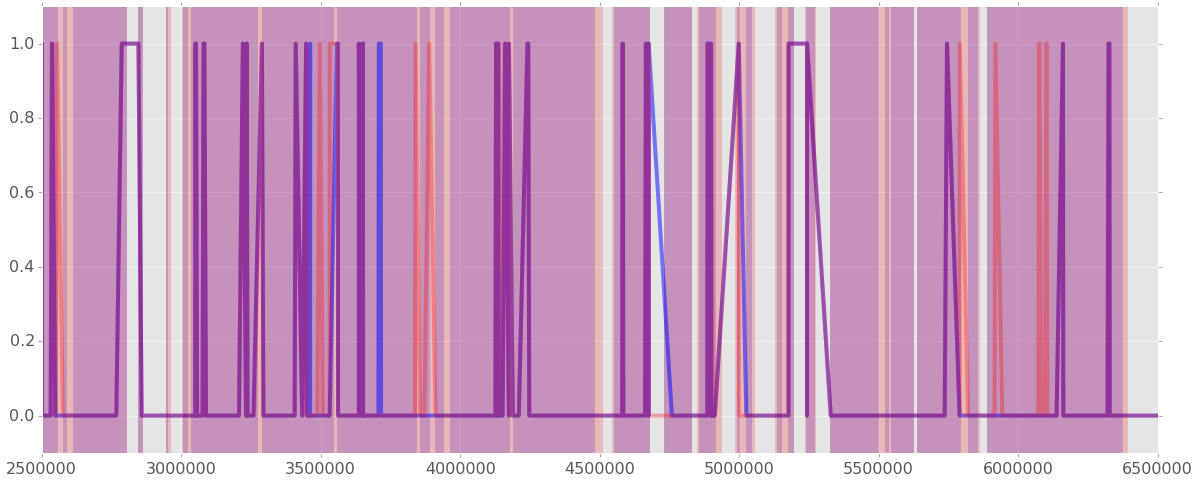

In [207]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'
fig, ax = plt.subplots()

for s,e in bs_s:
    ax.axvspan(s,e,ymin=0, ymax=2500000, alpha=0.2, color='b')
for s,e in bs:
    ax.axvspan(s,e,ymin=0, ymax=2500000, alpha=0.2, color='r')
ax.plot(switchpos_list_s, switch_list_s, color='b', alpha=0.5, lw=4)
ax.plot(switchpos_list, switch_list, color='r', alpha=0.3, lw=4) #methyl
ax.set_xlim([2500000,6500000])
ax.set_ylim([-0.1,1.1])
plt.show()

In [68]:
phaseLocalRegions (vcf_fn, hapcut_fn1)
phaseLocalRegions (vcf_fn, hapcut_fn2)
phaseLocalRegions (vcf_fn, hapcut_fn3)
phaseLocalRegions (vcf_fn, hapcut_fn4)

opening vcf file /Users/alibashir/sshfs/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf
reading vcf file . . .
...reading chrom 000000F
...read 100000 vars
...reading chrom 000001F
...exiting out of function early after first contig
finished reading vcf file
reading hapcut blocks: 
opening vcf file /Users/alibashir/sshfs/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf
reading vcf file . . .
...reading chrom 000000F
...read 100000 vars
...reading chrom 000001F

switches              : 3294
concordant snps       : 6384
total snps in blocks  : 73369
missing from trio snps: 14845
missing from file snps: 46911
other missing     snps: 0
denominator snps      : 11613
haplotype accuracy    : 0.549729
switch error rate     : 0.283648
S50: 58877
N50: 27040168
switches              : 4262


...exiting out of function early after first contig
finished reading vcf file
reading hapcut blocks: 
opening vcf file /Users/alibashir/sshfs/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf
reading vcf file . . .
...reading chrom 000000F
...read 100000 vars
...reading chrom 000001F


concordant snps       : 11697
total snps in blocks  : 51861
missing from trio snps: 26575
missing from file snps: 7723
other missing     snps: 0
denominator snps      : 17563
haplotype accuracy    : 0.666002
switch error rate     : 0.242669
S50: 1103
N50: 626525
switches              : 410


...exiting out of function early after first contig
finished reading vcf file
reading hapcut blocks: 
opening vcf file /Users/alibashir/sshfs/jason_new/trio_analysis/aj_trio_phasebytrans.phased-trio.vcf
reading vcf file . . .
...reading chrom 000000F
...read 100000 vars
...reading chrom 000001F


concordant snps       : 7155
total snps in blocks  : 19682
missing from trio snps: 11458
missing from file snps: 136
other missing     snps: 0
denominator snps      : 8088
haplotype accuracy    : 0.884644
switch error rate     : 0.050692
S50: 204
N50: 220011
switches              : 336
concordant snps       : 7049
total snps in blocks  : 19901
missing from trio snps: 11622
missing from file snps: 148
other missing     snps: 0
denominator snps      : 8131
haplotype accuracy    : 0.866929
switch error rate     : 0.041323
S50: 259
N50: 287557



...exiting out of function early after first contig
finished reading vcf file
reading hapcut blocks: 
